# Differentiation matrices

In this notebook we will learn how to

* differentiate using differentiation matrices (`diffmatrix` and `expsolve.linalg.matmul`),
* and compute their exponential (`torch.matrix_exp`).

[Back to tensorgrid quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import time

import numpy as np

import matplotlib.pyplot as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex

import torch
from torch import exp, sin, cos, abs, real, imag, pi, max, diag, float32, eye, kron
from torch.linalg import norm, matrix_exp

error = lambda u, uref : max(abs(u.flatten()-uref.flatten()))

## Differentiation Matrix

The differentation operator `diffop` is a function that differentiates a function `u`. This is a linear differentiation operator $D(u)$ which is a linear transformation, i.e. $D( a u + b v) = a D(u) + b D(v)$. All linear transformations have a matrix representation, and thus we must have a *matrix* $\mathbf{D}$ such that 

$$ D(u) = \mathbf{D} u$$

The way the (Fourier) differentiation operator `diffop` (i.e. $D$) is implemented, it uses FFT and thus costs $\mathcal{O}\left(n \log n\right)$, which is much more efficient than creating and storing the $n \times n$ matrix $\mathbf{D}$ and computing the matrix-vector product $\mathbf{D} u$, which costs $\mathcal{O}\left(n^2 \right)$.

#### $\star$ `diffmatrix` and `expsolve.linalg.matmul`



However, sometimes we might want access to differentiation matrices such as $\mathbf{D}$. `tensorgrid` provides the `diffmatrix` function with the following syntax for this purpose:

```Python
    D = ex.diffmatrix(1, n, xrange)
```

where `D` is the first differentiation matrix (i.e. for computing the first derivative), `n` is the size of the matrix ($n \times n$) and `xrange` is as before. 

To differentiate a function `f` discretised on a grid on `xrange` with `n` points, we need to compute the matrix-vector product $\mathbf{D} f$.
For computing matrix-vector products in `expsolve` you should always use the the `matmul` function in `expsolve.linalg`. We have imported `expsolve` as `es`, so we need to compute

```Python
    ds = es.linalg.matmul(D, f)
```

* As always, the default value of `xrange` is `[-1,1]`.
* For even derivatives, differentiation matrix is real-valued. For odd derivatives it is complex-valued.
* `expsolve.linalag.matmul` does useful pre and post-processing such as takes caring of converting `D` and `s` to complex if either is complex, and is broadcast compatible. 
* It is recommended that you **do not try to use the `@` matrix multiplication operator instead of `matmul`**.

Here is an example of computing the second derivative by multiplying with the second differentation matrix:

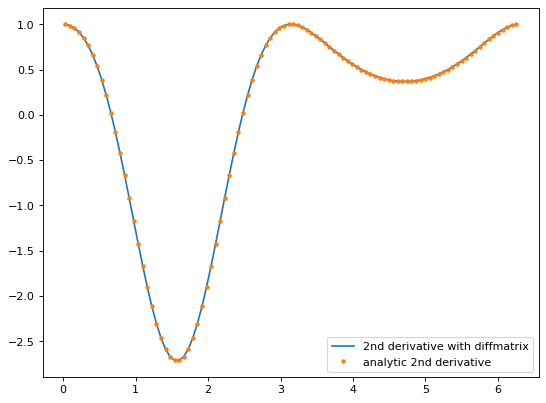

In [3]:
xrange = [0, 2*pi]
n = 100
x = ex.grid1d(n, xrange)

f = exp(sin(x))
d2f_true = -sin(x)*exp(sin(x)) + (cos(x)**2)*exp(sin(x))

D2 = ex.diffmatrix(2, n, xrange)            

D2f = es.linalg.matmul(D2, f)                  # matrix vector product 

plt.figure(figsize=(8, 6), dpi=80)
ex.plot(plt, x, D2f)
ex.plot(plt, x, d2f_true, marker='.',linestyle=' ')
plt.legend(['2nd derivative with diffmatrix', 'analytic 2nd derivative'])
plt.show()

Let's see what the error in computing second derivative with the differentiation matrix is.

In [4]:
print(max(abs(es.linalg.matmul(D2, f) - d2f_true.flatten())))

tensor(1.7834e-12, dtype=torch.float64)


## Why prefer differential operators over differentiation matrices?

This is only relevant for the Fourier differentiation matrices, not finite difference. 

The Fourier differentiation matrices can be diagonalized with Fourier matrices $\mathcal{F}$:

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} $$
where $s_k$ is the symbol of $\mathbf{D}_k$ (in particular, the $j$ th component of $s_k$ is $(s_k)_j = (-i j \pi)^k$). You can create an $n \times n$ Fourier matrix $\mathcal{F}$ in `tensorgrid` as `ex.cfftmatrix(n)`, although we will not be doing so explicitly.



In `tensogrid`, the function `diffop` computes the action of $\mathbf{D}_k$ on vector `u` as 

$$ \mathbf{D}_k = \mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u = \texttt{ifft}\left(s_k\ \texttt{fft}(u) \right) $$

While the first form - $\mathcal{F}^{-1} \texttt{diag}(s_k) \mathcal{F} u$ - requires $\mathcal{O}(n^2)$ operations, the second form - $\texttt{ifft}\left(s_k\ \texttt{fft}(u) \right)$ - only involves comuting the FFT and inverse FFT, and can be computed in $\mathcal{O}(n \log n)$ operations. This is why `diffop` is preexrred to `diffmatrix` followed by matrix-vector multiplication, which costs $\mathcal{O}(n^2)$ cost and storage.

## Differentiation matrices in higher dimensions

`tensorgrid` does not explicitly provide a way to create differentiation matrices in higher dimensions. Partly this is due to the inefficiencies of doing so, but also since it is simple enough to do if you require. To do so, you only need to `kron` with appropriate identity matrices. 

In the following example, we recall the function

$$ f= \sin(x+2y) + \exp(\sin(y)) \cos(y)$$

that we had encountered earlier in the 2D example for `diffop`. However, we now consider it on the spatial domain $[0, 2 \pi] \times [-\pi, \pi]$, and discretize it with `23` points in the `x` direction and `62` in the `y` direction. 

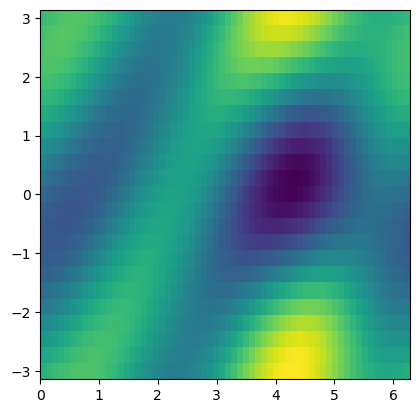

In [5]:
xrange = np.array([[0, 2*pi],[-pi,pi]])
n = [23, 62]
[x, y] = ex.grid(n, xrange)

f = sin(x+2*y) + exp(sin(y))*cos(x)
ex.imshow(plt, xrange, f)
plt.show()

The differential operator $\frac{\partial^2}{\partial x^2}$ is represented by a matrix 

$$ \mathbf{D}_{xx} = \mathbf{D}_2 \otimes \mathbf{I} $$

where $\otimes$ is the tensorization operator `kron`. The dimensions of `D2` and `I` need to match the underlying spatial dimensions. That is, `D2` needs to match the spatial grid size in `x` direction and `I` needs to match the grid size in the `y` direction. In our example we have deliberately used different grid sizes in `x` and `y` directions. 

Consequently, we need two different copies of `D2` and `I` depending on whether they are acting on `x` or `y`. We call these `D2a`, `D2b` and `Ia`, `Ib` respectively. 

In [6]:
Ia = eye(n[0])
Ib = eye(n[1])

D2a = ex.diffmatrix(2, n[0], xrange)
D2b = ex.diffmatrix(2, n[1], xrange)

We then create the differential matrices `Dxxm` and `Dyym` that correspond to second derivatives in direction `x` and `y` respectively, as well as the Laplacian matrix.

In [7]:
Dxxm = kron(D2a, Ib)
Dyym = kron(Ia, D2b)
Lapm = Dxxm + Dyym

To compare these to `diffop`, we redefine `Dxx` and `Dyy` (this is important since `xrange` has changed).

In [8]:
Dxx = lambda f: ex.diffop(0, 2, f, xrange)
Dyy = lambda f: ex.diffop(1, 2, f, xrange)
Lap = lambda f: Dxx(f) + Dyy(f)

In [9]:
print(error( es.linalg.matmul(Dxxm, f) , Dxx(f) ))
print(error( es.linalg.matmul(Dyym, f) , Dyy(f) ))
print(error( es.linalg.matmul(Lapm, f) , Lap(f)))

tensor(2.1588e-07, dtype=torch.float64)
tensor(2.4422e-07, dtype=torch.float64)
tensor(2.2935e-07, dtype=torch.float64)


The error is higher here since the grids are not fine enough. To see the effect, set `n = [100, 100]` at the beginning of this example.

## Exponentials of differential matrices

#### $\star$ `matrix_exp`

The exponential of the differentiation matrix can be computed using `torch`'s `matrix_exp` function. 

We compare the matrix approach to `diffopexp`, `laplaciansymbol` and `laplacianopexp` approach, although the latter have not been introduced yet. These are introduced in the following notebooks, but the speedup should serve as a motivation for why the differential operator approach is superior in the case of Fourier differentiation.

In [ ]:
xrange = [0, 2*pi]
n = 100

x = ex.grid1d(n, xrange)
f = exp(sin(x))

D2 = ex.diffmatrix(2, n, xrange)            
expD2 = matrix_exp(0.1*D2)
expD2f = es.linalg.matmul(expD2, f)

expd2f = ex.diffopexp(0, 2, 0.1, f, xrange)

print(error(expD2f, expd2f))

tensor(5.3202e-13, dtype=torch.float64)


We can do the same for higher dimensions. For simplicity, we consider the case where spatial domain is $[0, 2 \pi]^2$ and `nx=ny=50`.

In [ ]:
xrange = [0, 2*pi]
n = [50, 50]
I = eye(n[0])
D2 = ex.diffmatrix(2, n[0], xrange)            

Dxx = kron(D2, I)
Dyy = kron(I, D2)
Lap = Dxx + Dyy

x, y = ex.grid(n, xrange)
f = sin(x+2*y) + exp(sin(y))*cos(x)

tim1 = time.time()
expL = matrix_exp(0.1*Lap)
expLf = es.linalg.matmul(expL, f)
tim2 = time.time()
print(f'matrix_exp approach took {tim2-tim1}s')

tim1 = time.time()
SL = ex.laplaciansymbol(ex.fouriersymbol, n, xrange)
expLfS = ex.laplacianopexp(SL, 0.1, f)
tim2 = time.time()
print(f'fourier symbol approach took {tim2-tim1}s')

print(error(expLf, expLfS))

matrix_exp approach took 8.453601598739624s
fourier symbol approach took 0.005003213882446289s
tensor(3.0768e-10, dtype=torch.float64)


This speedup should serve as a strong motivation for the Fourier symbol approach described in notebooks 04-05.